In [31]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [3]:
df = pd.read_csv("RCV_DataPrep.csv")

In [4]:
df.columns = df.columns.str.lower()

In [5]:
# Filtrar filas donde id_persona no es nulo
df_filtrado = df[df['id_persona'].notna()].copy()


# Seleccionar columnas deseadas
columnas = [
    'id_persona', 'sexo', 'edad', 'hta', 'dm', 'pas', 'pad', 'imc', 'imcanterior', 'peso', 'pesoanterior',
    'g22-1', 'g22-2', 'c86-1', 'g06',
    'perimetroabdominal', 'actividadfisica', 'alimentacion', 'antihipertensivos',
    'testfindrisc', 'resultadocreatininaactual', 'resultadocreatininaanterior',
    'tfgcygactual', 'tfgcyganterior', 'tfgactual', 'tfganterior',
    'albuminuria', 'microalbuminuria', 'proteinuria',
    'rcv'
]

resultado = df_filtrado[columnas]


In [7]:
columnas_numericas = ['hta', 'dm', 'pas', 'pad', 'imc', 'imcanterior', 'peso', 'pesoanterior',
           'g22-1', 'g22-2', 'c86-1', 'g06', 'perimetroabdominal',
           'testfindrisc', 'resultadocreatininaactual',
           'resultadocreatininaanterior', 'tfgcygactual', 'tfgcyganterior', 'tfgactual', 'tfganterior',
           'albuminuria', 'microalbuminuria', 'proteinuria']

for c in columnas_numericas:
    resultado[c] = resultado[c].astype(str).str.replace(',', '.', regex=False)
    resultado[c] = pd.to_numeric(resultado[c], errors='coerce')

resultado_final = resultado.replace("NULL", np.nan)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_12764\3715427255.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultado[c] = resultado[c].astype(str).str.replace(',', '.', regex=False)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_12764\3715427255.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultado[c] = pd.to_numeric(resultado[c], errors='coerce')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_12764\3715427255.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

# Eliminación de variables con muchos NA

Teniendo en cuenta que tenemos variables con muchos NA, buscaremos las que sobre pasen el 90%.

* c86-1
* g22-1
* g22-2
* alimentacion
* antihipertensivos
* microalbuminuria
* proteinuria

In [10]:
# Contar NaNs y calcular porcentaje
na_counts = resultado_final.isna().sum()
na_percent = (na_counts / len(resultado_final)) * 100

# Filtrar columnas con al menos un NaN
tabla = [
    [col, na_counts[col], f"{na_percent[col]:.2f}%"]
    for col in resultado_final.columns if na_counts[col] > 0
]

# Mostrar tabla bonita
print(tabulate(tabla, headers=['Columna', 'NAs', 'Porcentaje'], tablefmt='github'))

| Columna                     |   NAs | Porcentaje   |
|-----------------------------|-------|--------------|
| pas                         |  1922 | 38.44%       |
| pad                         |  1922 | 38.44%       |
| imc                         |  1181 | 23.62%       |
| imcanterior                 |  1157 | 23.14%       |
| peso                        |  1158 | 23.16%       |
| pesoanterior                |  1157 | 23.14%       |
| g22-1                       |  4965 | 99.30%       |
| g22-2                       |  4965 | 99.30%       |
| c86-1                       |  4971 | 99.42%       |
| g06                         |  3412 | 68.24%       |
| perimetroabdominal          |  4099 | 81.98%       |
| actividadfisica             |  2897 | 57.94%       |
| alimentacion                |  4655 | 93.10%       |
| antihipertensivos           |  5000 | 100.00%      |
| resultadocreatininaactual   |  3306 | 66.12%       |
| resultadocreatininaanterior |  4465 | 89.30%       |
| tfgcygac

# Cálculo de matriz de correlaciones

Para evitar utilizar columnas con correlaciones muy altas (mayor a 80%) que haría tener redundancias y hacer más pesado el modelo, haremos una matriz de correlación para eliminar ciertas columnas:

* pesoanterior
* tfgcyganterior
* resultadocreatininaanterior
* pesoanterior
* tfganterior

De dichas correlaciones altas y hablando con un experto, se decidieron dejar las siguientes columnas así tuvieran correlación alta:
* PAS (Presión Arterial Sistólica)
* PAD (Presión Arterial Diastólica)
* IMC
* Peso
* Perímetro abdominal

In [53]:
# Calcula la matriz de correlación para esas columnas
matriz_corr = resultado_final[columnas_numericas].corr().abs()  # Correlación absoluta

# Lista para guardar resultados
correlaciones_altas = []

# Iterar solo por la parte superior de la matriz para evitar duplicados y diagonal
for i in range(len(columnas_numericas)):
    for j in range(i+1, len(columnas_numericas)):
        corr_value = matriz_corr.iloc[i, j]
        if corr_value > 0.8:
            correlaciones_altas.append({
                'Columna 1': columnas_numericas[i],
                'Columna 2': columnas_numericas[j],
                'Correlación': corr_value
            })

# Crear DataFrame resultado ordenado
df_correlaciones_altas = pd.DataFrame(correlaciones_altas).sort_values(by='Correlación', ascending=False)

# Mostrar tabla bonita
import tabulate
print(tabulate.tabulate(df_correlaciones_altas, headers='keys', tablefmt='pretty', floatfmt=".3f"))

+---+-----------------------------+-----------------------------+--------------------+
|   |          Columna 1          |          Columna 2          |    Correlación     |
+---+-----------------------------+-----------------------------+--------------------+
| 3 |            peso             |        pesoanterior         | 0.979275743758456  |
| 7 |        tfgcygactual         |       tfgcyganterior        | 0.8702983078329973 |
| 0 |             pas             |             pad             | 0.8665068447310846 |
| 4 |  resultadocreatininaactual  | resultadocreatininaanterior | 0.8595249491092251 |
| 1 |             imc             |            peso             | 0.8450581496636731 |
| 2 |             imc             |        pesoanterior         | 0.826614792236572  |
| 8 |          tfgactual          |         tfganterior         | 0.8198487045241581 |
| 6 | resultadocreatininaanterior |         tfganterior         | 0.8091425998480428 |
| 5 |  resultadocreatininaactual  |        

# Selección de variables para el modelo:

Para el modelo, tomaremos las siguientes variables teniendo en cuenta el análisis anterior:

| id_persona | sexo | edad | hta | dm | pas | pad | imc | albuminuria | rcv | tfgactual | 
|------------|------|------|-----|----|-----|-----|-----|-------------|-----|-----------|

| peso | perimetroabdominal | actividadfisica | testfindrisc | resultadocreatininaactual | tfgcygactual |
|------|---------------------|------------------|--------------|----------------------------|--------------|


In [ ]:
# Seleccionar columnas específicas
cols = ['id_persona', 'sexo', 'edad', 'hta', 'dm', 'pas', 'pad', 'imc', 'peso',
        'perimetroabdominal', 'actividadfisica', 'testfindrisc', 'resultadocreatininaactual',
        'tfgcygactual', 'tfgactual', 'albuminuria', 'rcv']

# Filtrar filas donde 'id_persona' no es nulo
resultado_final = resultado_final.loc[resultado_final['id_persona'].notnull(), cols].copy()

In [14]:
resultado_final.to_csv("DatosMelos.csv",index=False)

# GRÁFICAS Y ANÁLISIS DESCRIPTIVO

In [20]:
# Simular lectura
data = pd.read_csv('DatosMelos.csv')

# 1. Revisión inicial
# print(tabulate(data.head(), headers='keys', tablefmt='psql'))

print("\nTipos y datos faltantes:")
print(tabulate(data.isnull().sum().to_frame('faltantes'), headers='keys', tablefmt='psql'))



Tipos y datos faltantes:
+---------------------------+-------------+
|                           |   faltantes |
|---------------------------+-------------|
| id_persona                |           0 |
| sexo                      |           0 |
| edad                      |           0 |
| hta                       |           0 |
| dm                        |           0 |
| pas                       |        1922 |
| pad                       |        1922 |
| imc                       |        1181 |
| peso                      |        1158 |
| perimetroabdominal        |        4099 |
| actividadfisica           |        2897 |
| testfindrisc              |           0 |
| resultadocreatininaactual |        3306 |
| tfgcygactual              |        3543 |
| tfgactual                 |        3307 |
| tfganterior               |        4473 |
| albuminuria               |        4488 |
| rcv                       |           0 |
+---------------------------+-------------+


In [21]:
print("\nEstadísticas descriptivas variables numéricas:")
print(tabulate(data.describe().T, headers='keys', tablefmt='psql'))


Estadísticas descriptivas variables numéricas:
+---------------------------+---------+-------------+-------------+----------+-----------+-----------+-----------+------------+
|                           |   count |        mean |         std |      min |       25% |       50% |       75% |        max |
|---------------------------+---------+-------------+-------------+----------+-----------+-----------+-----------+------------|
| id_persona                |    5000 | 4952.31     | 2901.45     |  1       | 2405      | 4879.5    | 7528      | 10000      |
| edad                      |    5000 |   43.7232   |   22.4951   |  0       |   24      |   46      |   63      |   100      |
| hta                       |    5000 |    0.124    |    0.329615 |  0       |    0      |    0      |    0      |     1      |
| dm                        |    5000 |    0.047    |    0.21166  |  0       |    0      |    0      |    0      |     1      |
| pas                       |    3078 |  115.796    |   

In [22]:
print("\nConteo variables categóricas:")
for col in ['sexo', 'hta', 'dm', 'actividadfisica', 'rcv']:
    print(f"\n{col}:\n{tabulate(data[col].value_counts(dropna=False).to_frame('count'), headers='keys', tablefmt='psql')}")


Conteo variables categóricas:

sexo:
+-----------+---------+
| sexo      |   count |
|-----------+---------|
| Femenino  |    3440 |
| Masculino |    1560 |
+-----------+---------+

hta:
+-------+---------+
|   hta |   count |
|-------+---------|
|     0 |    4380 |
|     1 |     620 |
+-------+---------+

dm:
+------+---------+
|   dm |   count |
|------+---------|
|    0 |    4765 |
|    1 |     235 |
+------+---------+

actividadfisica:
+-------------------+---------+
|   actividadfisica |   count |
|-------------------+---------|
|               nan |    2897 |
|                 0 |    1994 |
|                 1 |     109 |
+-------------------+---------+

rcv:
+-------+---------+
|   rcv |   count |
|-------+---------|
|     0 |    2959 |
|     1 |    2041 |
+-------+---------+


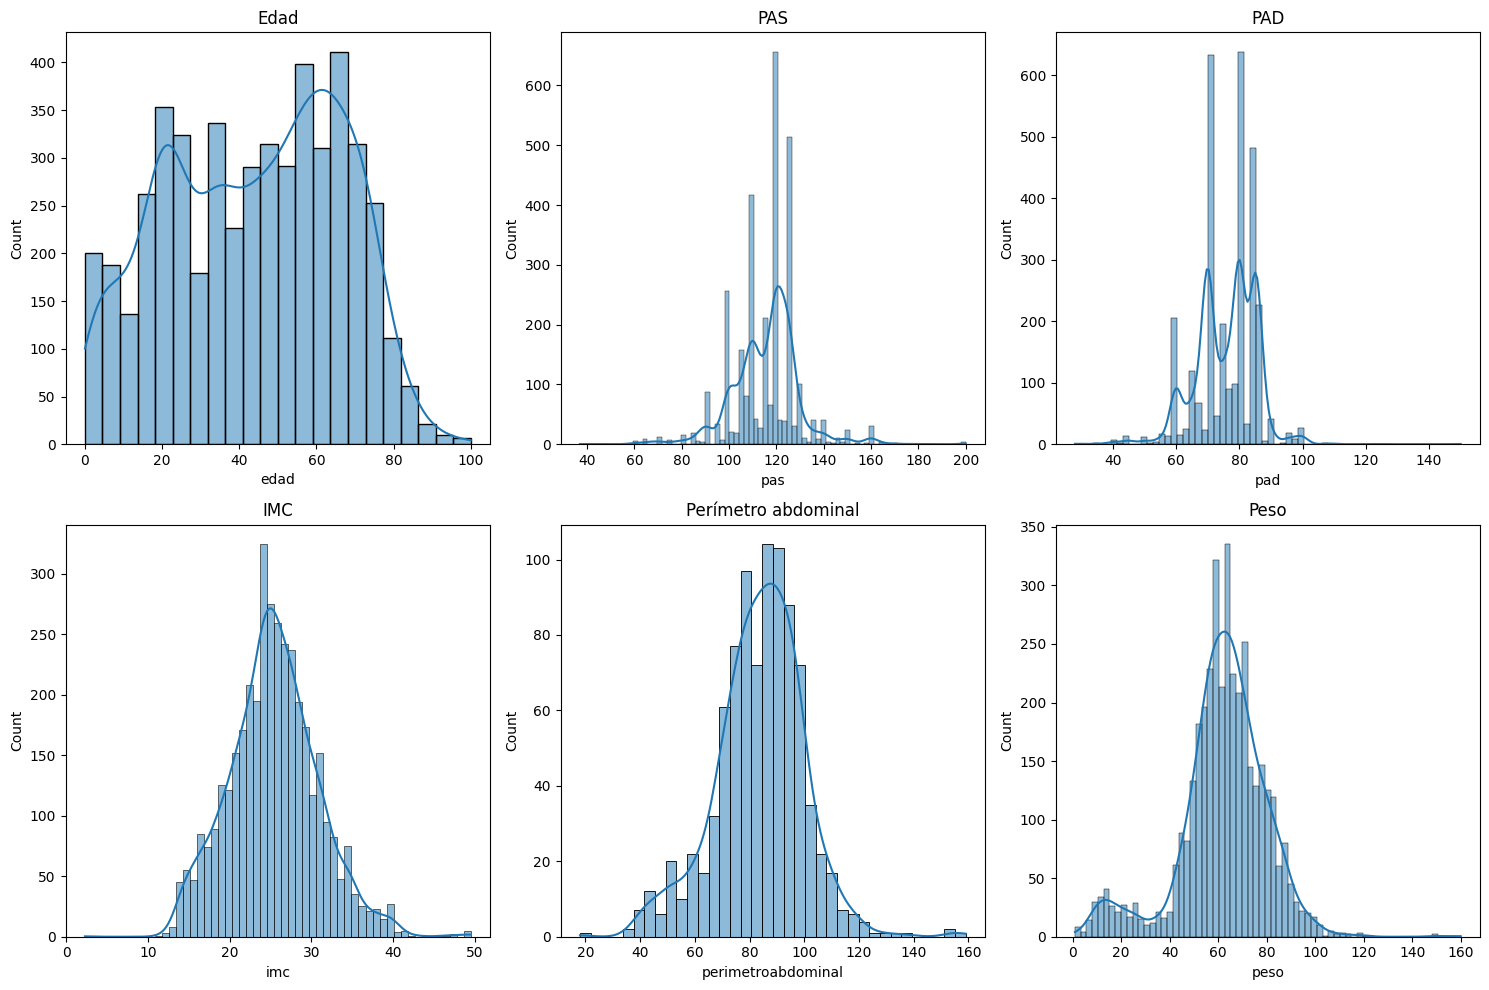

In [23]:
# 2. Distribución edad, PAS, PAD, IMC, perímetro abdominal
fig, axes = plt.subplots(2,3, figsize=(15,10))
sns.histplot(data['edad'].dropna(), ax=axes[0,0], kde=True).set_title('Edad')
sns.histplot(data['pas'].dropna(), ax=axes[0,1], kde=True).set_title('PAS')
sns.histplot(data['pad'].dropna(), ax=axes[0,2], kde=True).set_title('PAD')
sns.histplot(data['imc'].dropna(), ax=axes[1,0], kde=True).set_title('IMC')
sns.histplot(data['perimetroabdominal'].dropna(), ax=axes[1,1], kde=True).set_title('Perímetro abdominal')
sns.histplot(data['peso'].dropna(), ax=axes[1,2], kde=True).set_title('Peso')
plt.tight_layout()
plt.show()

In [24]:
# 3. Tabla resumen (media ± std, mediana, min, max) para variables clínicas
vars_clinicas = ['edad','pas','pad','imc','perimetroabdominal','peso','resultadocreatininaactual', 'tfgactual']
summary = data[vars_clinicas].agg(['mean','std','median','min','max']).T
summary['mean ± std'] = summary.apply(lambda r: f"{r['mean']:.2f} ± {r['std']:.2f}", axis=1)
summary_final = summary[['mean ± std','median','min','max']]
print("\nResumen variables clínicas:")
print(tabulate(summary_final, headers='keys', tablefmt='psql'))


Resumen variables clínicas:
+---------------------------+----------------+----------+----------+----------+
|                           | mean ± std     |   median |      min |      max |
|---------------------------+----------------+----------+----------+----------|
| edad                      | 43.72 ± 22.50  |  46      |  0       | 100      |
| pas                       | 115.80 ± 14.08 | 120      | 37       | 200      |
| pad                       | 75.92 ± 9.55   |  78      | 28       | 150      |
| imc                       | 25.43 ± 5.44   |  25.3155 |  2.28624 |  49.5317 |
| perimetroabdominal        | 83.71 ± 16.24  |  85      | 18       | 159      |
| peso                      | 61.93 ± 18.18  |  63      |  1       | 160      |
| resultadocreatininaactual | 0.89 ± 0.24    |   0.86   |  0.17    |   3.19   |
| tfgactual                 | 88.24 ± 22.96  |  88.2596 | 17.2736  | 195.92   |
+---------------------------+----------------+----------+----------+----------+


# Comparar medias entre los grupos rcv = 0 y rcv = 1 usando la prueba t de Student.

Se compararon las medias de variables clínicas entre dos grupos: pacientes sin riesgo cardiovascular (RCV = 0) y con riesgo cardiovascular (RCV = 1). Todos los p-valores fueron < 0.0001, lo que indica que las diferencias son estadísticamente significativas.

Conclusiones:

**Edad**: El grupo con RCV tiene una media de edad significativamente mayor (59.6 años vs. 32.8 años), con un tamaño del efecto muy grande (d = -1.47).

**Presión arterial (PAS y PAD)**: Ambos valores son mayores en el grupo con RCV, con tamaños del efecto grandes (d ≈ -0.8 a -1.0).

**IMC y perímetro abdominal**: Son más altos en el grupo con RCV, lo que indica mayor prevalencia de sobrepeso/obesidad (d ≈ -0.9).

**Peso corporal**: También mayor en el grupo RCV, aunque con un tamaño del efecto algo menor (d = -0.76).

**Creatinina sérica**: Ligeramente mayor en el grupo con RCV, con un efecto moderado (d = -0.4).

**TFG (tasa de filtración glomerular)**: Es significativamente menor en el grupo con RCV, lo que puede indicar función renal comprometida. El tamaño del efecto es grande y positivo (d = 0.87), porque una TFG más baja es peor clínicamente.

In [28]:
# Función para calcular el d de Cohen (tamaño del efecto)
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    s1, s2 = np.std(x, ddof=1), np.std(y, ddof=1)
    s_pooled = np.sqrt(((nx - 1) * s1**2 + (ny - 1) * s2**2) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / s_pooled if s_pooled != 0 else 0

# Comparación de medias y estadísticas
resultados = []

print("### Comparación de medias por rcv (0 vs 1):\n")
for var in vars_clinicas:
    grupo0 = data[data['rcv'] == 0][var].dropna()
    grupo1 = data[data['rcv'] == 1][var].dropna()

    if len(grupo1) > 5:
        stat, p = ttest_ind(grupo0, grupo1, equal_var=False)
        d = cohen_d(grupo0, grupo1)
        resultados.append({
            'Variable': var,
            'Media_RCV_0': np.mean(grupo0),
            'SD_RCV_0': np.std(grupo0, ddof=1),
            'Media_RCV_1': np.mean(grupo1),
            'SD_RCV_1': np.std(grupo1, ddof=1),
            'p_value': p,
            'Cohen_d': d
        })
    else:
        print(f"{var}: no hay suficientes datos con rcv=1")

# Convertir a DataFrame para mostrar
df_resultados = pd.DataFrame(resultados)

# Redondear para mejor visualización
df_resultados = df_resultados.round({
    'Media_RCV_0': 2,
    'SD_RCV_0': 2,
    'Media_RCV_1': 2,
    'SD_RCV_1': 2,
    'p_value': 4,
    'Cohen_d': 2
})

# Imprimir con tabulate
print(tabulate(df_resultados.sort_values('p_value'), headers='keys', tablefmt='github', floatfmt=".2f"))

### Comparación de medias por rcv (0 vs 1):

|    | Variable                  |   Media_RCV_0 |   SD_RCV_0 |   Media_RCV_1 |   SD_RCV_1 |   p_value |   Cohen_d |
|----|---------------------------|---------------|------------|---------------|------------|-----------|-----------|
|  0 | edad                      |         32.80 |      20.78 |         59.56 |      13.79 |      0.00 |     -1.47 |
|  1 | pas                       |        109.42 |      13.46 |        121.76 |      11.85 |      0.00 |     -0.98 |
|  2 | pad                       |         72.11 |       9.94 |         79.48 |       7.61 |      0.00 |     -0.84 |
|  3 | imc                       |         23.14 |       5.39 |         27.63 |       4.50 |      0.00 |     -0.91 |
|  4 | perimetroabdominal        |         76.70 |      16.97 |         90.26 |      12.38 |      0.00 |     -0.92 |
|  5 | peso                      |         55.37 |      20.40 |         68.27 |      12.88 |      0.00 |     -0.76 |
|  6 | resultadocre

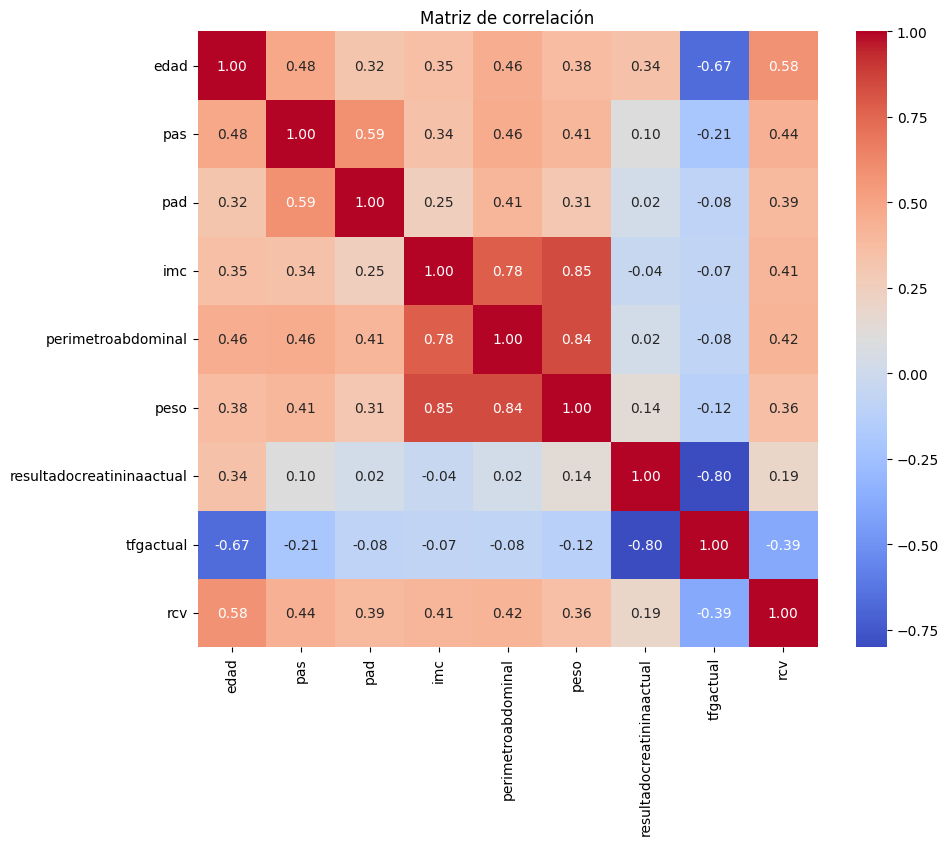

In [29]:
# 5. Correlación
corr = data[vars_clinicas + ['rcv']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()

# Tablas de contingencia para variables categóricas

Ambas variables (hta y dm) presentan un p-valor = 0.0000 en el test Chi², lo que indica una asociación estadísticamente significativa con el riesgo cardiovascular (rcv).

## ¿Qué significa?
Todas las personas con hipertensión (hta = 1) y con diabetes (dm = 1) se encuentran en el grupo de alto riesgo (rcv = 1).
Esto sugiere una separación perfecta en la muestra: la presencia de hta o dm predice completamente el valor de rcv.

## Consecuencias en modelado

**Separación perfecta:**

En modelos como regresión logística, los coeficientes se vuelven infinitos o inestables.

La optimización no converge o produce advertencias técnicas.

### Sobreajuste:

El modelo puede aprender reglas demasiado estrictas (ej. si hta = 1, entonces rcv = 1), lo que lleva a bajo rendimiento en datos nuevos o reales.

### Importancia sesgada:

Algoritmos como árboles de decisión o random forest podrían depender casi exclusivamente de hta y dm, ignorando otras variables relevantes.

In [ ]:
from scipy.stats import chi2_contingency
from tabulate import tabulate
import pandas as pd

for col in ['sexo', 'hta', 'dm', 'actividadfisica']:
    df_filtrado = data[[col, 'rcv']].dropna()
    
    if df_filtrado.empty:
        continue
    
    tabla = pd.crosstab(df_filtrado[col], df_filtrado['rcv'])
    
    if tabla.shape[0] < 2 or tabla.shape[1] < 2:
        continue
    
    chi2, p, dof, ex = chi2_contingency(tabla)
    
    # Mostrar solo si es significativo
    if p < 0.05:
        print(f"\nTabla {col} vs rcv:")
        print(tabulate(tabla, headers='keys', tablefmt='psql'))
        print(f"Chi2 p-value = {p:.4f}")



Tabla hta vs rcv:
+-------+------+------+
|   hta |    0 |    1 |
|-------+------+------|
|     0 | 2959 | 1421 |
|     1 |    0 |  620 |
+-------+------+------+
Chi2 p-value = 0.0000

Tabla dm vs rcv:
+------+------+------+
|   dm |    0 |    1 |
|------+------+------|
|    0 | 2959 | 1806 |
|    1 |    0 |  235 |
+------+------+------+
Chi2 p-value = 0.0000


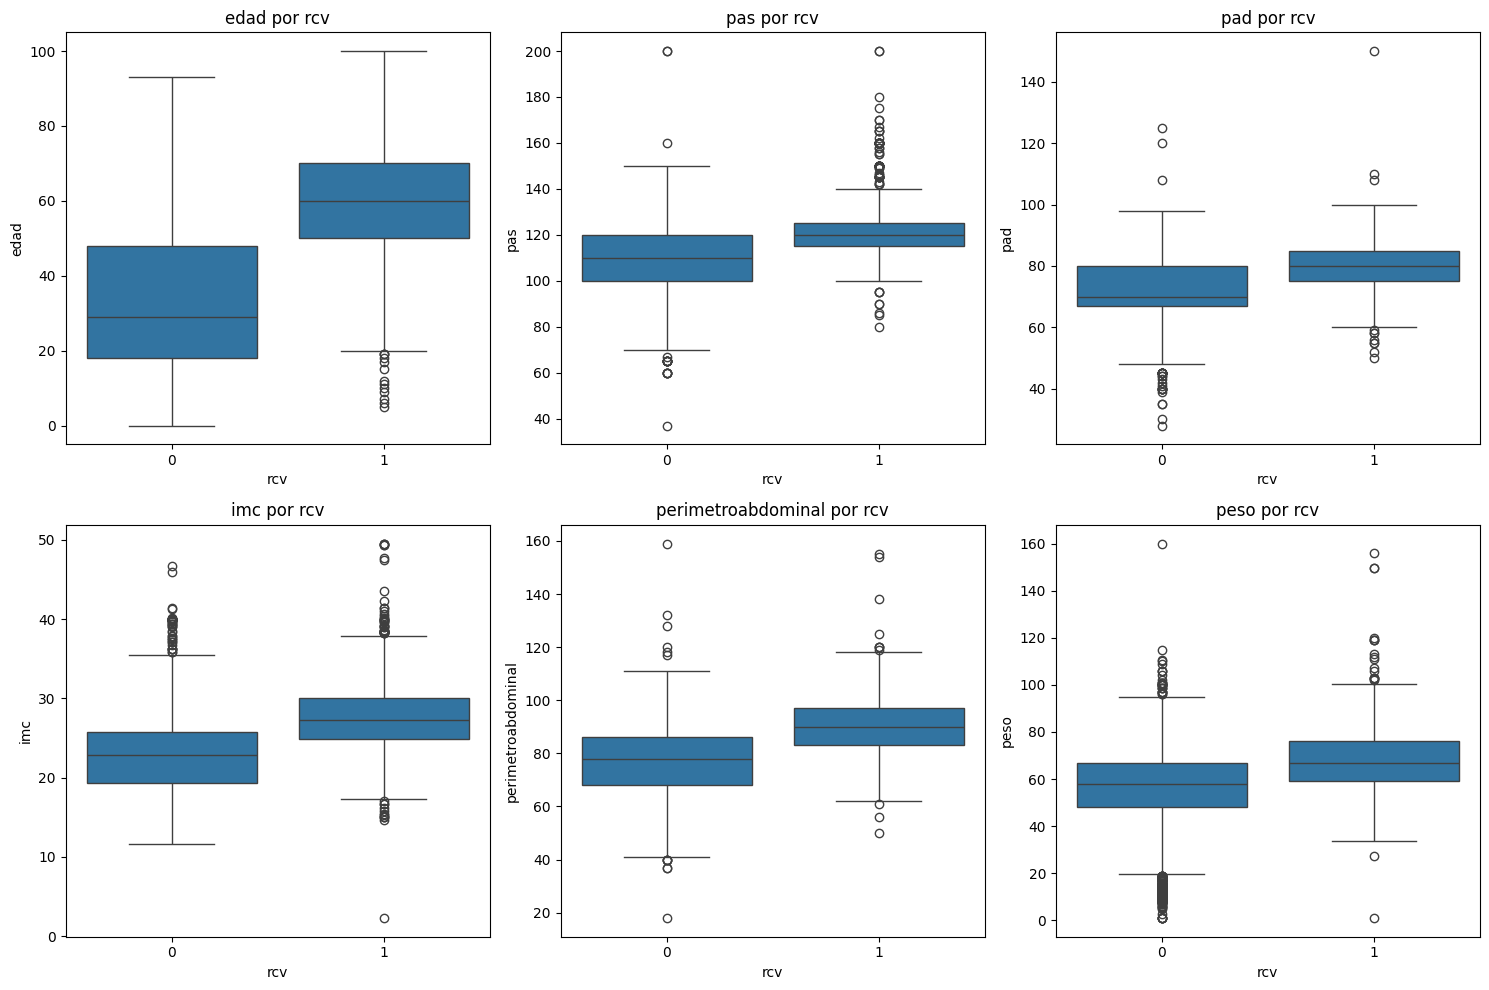

In [37]:
# 7. Gráficos boxplots de variables clínicas por rcv
fig, axes = plt.subplots(2,3, figsize=(15,10))
for ax, var in zip(axes.flatten(), vars_clinicas[:-1]):
    sns.boxplot(x='rcv', y=var, data=data, ax=ax)
    ax.set_title(f'{var} por rcv')
plt.tight_layout()
plt.show()